In [1]:
%pylab inline
from __future__ import print_function, division
import matplotlib
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Basics of a Finite Volume Method (Generalized Finite Differences) in Seismology

This notebook largely follows the Dormy and Tarantola Paper:

> Dormy, E., & Tarantola, A. (1995). Numerical simulation of elastic wave propagation using a finite volume method. Journal of Geophysical Research: Solid Earth, 100(B2), 2123–2133. http://dx.doi.org/10.1029/94JB02648

The *"finite volume method"* will be used to estimate the derivative at a given point. All the following equations assume a Cartesian coordinate system.

## Theorem of Gauss
    
The well known Gauss theorem states that the volume integral over the divergence of a field $F$ is equal to the integral of the flux over the bounding surface, $n_i$ is an outwards pointing unit normal vector.



$$ \int_V \partial_i w_i~dV = \int_S n_i w_i~dS$$

Apparently this is easy to generalize to the gradient of an arbitrary tensor field in Euclidean spaces...

$$ \int_V \partial_i W_{jk...}~dV = \int_S n_i W_{jk...}~dS $$

which in two dimensions ends up in

$$ \int_s \partial_i W_{jk...}~dS = \int_L n_i W_{jk...}~dL $$


## Discretization

For smooth enough fields this can be discretized with

$$ \Delta S  ~\partial_i V_{jk...} \approx \sum_{\alpha} \Delta L^{\alpha} n^{\alpha}_i V^{\alpha}_{jk...}$$

Therefore the derivative can be approximated with


$$\partial_i V_{jk...} \approx \frac{1}{\Delta S}\sum_{\alpha} \Delta L^{\alpha} n^{\alpha}_i V^{\alpha}_{jk...}$$

## Approximation of the first Derivative in a regular Grid

The whole thing can be done in arbitrary grids!

<img width="30%" src="lozenge.png"></img>

The normals are

$$n_{2,4} = \frac{1}{l}\left(
\begin{array}{c}
+\Delta_2\\
+\Delta_1\\
\end{array}
\right)
~~~~~~
n_{4, 1} = \frac{1}{l}\left(
\begin{array}{c}
-\Delta_2\\
+\Delta_1\\
\end{array}
\right)
~~~~~~ 
n_{1, 3} = \frac{1}{l}\left(
\begin{array}{c}
-\Delta_2\\
-\Delta_1\\
\end{array}
\right)
~~~~~~
n_{3, 2} = \frac{1}{l}\left(
\begin{array}{c}
+\Delta_2\\
-\Delta_1\\
\end{array}
\right)$$

Thus the derivative in direction 1 can be approximated with

*(sorry for being too lazy to type it...)*

<img width="40%" src="equation.png"></img>

This also works in the second space direction

$$ \partial_1 \phi = \frac{\phi_2 - \phi_1}{2 \Delta_1}$$

$$ \partial_2 \phi = \frac{\phi_4 - \phi_3}{2 \Delta_2}$$

This happens to be identical to centered finite differences in staggered grids...

## Regular and Irregular Lozenge Grid

![loz](lozange_grid.png)

## Regular and Irregular Hexagonal Grid

![hex](hexagonal.png)

In [2]:
import scipy.fftpack

class Source(object):
    def __init__(self, x, y, dt, npts):
        self.x = x
        self.y = y
        self.dt = dt
        self.source_time_shift = 100
        self.source_freq = 100.0
        # Dominant period.
        self.source_T = 1.0 / self.source_freq
        # Gaussian source time function.
        self.data = np.arange(npts, dtype="float64")
        self.data = np.exp(-1.0 / self.source_T ** 2 *
                           ((self.data - self.source_time_shift) * self.dt) ** 2)
        # Take the first derivative
        self.data = np.diff(self.data) / self.dt
        
        
class FiniteVolume(object):
    def __init__(self, length_x, length_y, dt, npts_x, npts_y,
                 space_derivative_type="second_order_FD"):
        self.length_x = length_x
        self.length_y = length_y
        self.dim_x = npts_x
        self.dim_y = npts_y
        self.dx = float(length_x / npts_x)
        self.dy = float(length_y / npts_y)
        self.dt = dt
        self.iteration_count = 0
        self.space_derivative_type = space_derivative_type
        self.source = Source(self.dim_x // 3, self.dim_y // 3, self.dt, 10000)
        self.setup_grid()
        
    def reset(self):
        self.iteration_count = 0
        for i in (self.p, self.p_old, self.p_new, self.p_xx, self.p_yy, self.p_x, self.p_y):
            i[...] = 0.0
        
    def setup_grid(self):
        shape = (self.dim_y, self.dim_x)
        self.p = np.zeros(shape)
        self.p_old = np.zeros(shape)
        self.p_new = np.zeros(shape)
        self.p_xx = np.zeros(shape)
        self.p_x = np.zeros(shape)
        self.p_yy = np.zeros(shape)
        self.p_y = np.zeros(shape)
        self.vel_model = np.ones(shape) * 3000
        self.vel_model[100:150, 200:220] -= 1000
        
    def second_space_derivative(self):
        # Different ways to approximate the second space derivatives.
        if self.space_derivative_type == "second_order_FD":
            self.p_xx[:, 2:-2] = -self.p[:,4:] + 16 * self.p[:, 3:-1] - 30 * \
                self.p[:, 2:-2] + 16 * self.p[:, 1:-3] - self.p[:, :-4]
            self.p_yy[2:-2, :] = -self.p[:-4, :] + 16 * self.p[1:-3, :] - 30 * \
                self.p[2:-2, :] + 16 * self.p[3:-1, :] -self.p[4:, :]
            self.p_xx /= (self.dx ** 2 * 12)
            self.p_yy /= (self.dy ** 2 * 12)
        elif self.space_derivative_type == "pseudospectral":
            # Second space derivative in x direction.
            k_x = scipy.fftpack.fftfreq(self.dim_x) / self.dx * 2.0 * np.pi
            self.p_xx[...] = scipy.fftpack.ifft((1j * k_x) ** 2.0 * scipy.fftpack.fft(self.p[...], axis=1), axis=1).real
            # Second space derivative in y direction.
            k_y = scipy.fftpack.fftfreq(self.dim_y) / self.dy * 2.0 * np.pi
            k_y.shape = (len(k_y), 1)
            self.p_yy[...] = scipy.fftpack.ifft((1j * k_y) ** 2.0 * scipy.fftpack.fft(self.p[...], axis=0), axis=0).real   
        elif self.space_derivative_type == "pseudo_finite_volume":
            self.p_x[:, :-1] = (self.p[:, 1:] - self.p[:, :-1]) / (self.dx)
            self.p_y[:-1, :] = (self.p[1:, :] - self.p[:-1, :]) / (self.dy)
            self.p_xx[:, 1:-1] = (self.p_x[:, 1:-1] - self.p_x[:, :-2]) / (self.dx)
            self.p_yy[1:-1, :] = (self.p_y[1:-1, :] - self.p_y[:-2, :]) / (self.dy)
        else:
            raise NotImplementedError
        
    def time_step(self):
        self.second_space_derivative()
        self.p_new = 2 * self.p - self.p_old + self.dt ** 2 * self.vel_model ** 2 * (self.p_xx + self.p_yy)
        self.p_new[self.source.x, self.source.y] += self.source.data[self.iteration_count]
        self.p_old, self.p = self.p, self.p_new
        self.iteration_count += 1
        
    def run_and_plot(self, plot_interval=50):
        plt.figure(figsize=(15, 8 * (self.length_y / self.length_x)))
        self.reset()
        gs = matplotlib.gridspec.GridSpec(2, 5, left=0.0, right=1.0, bottom=0.0,
                                  top=1.0, wspace=0.0, hspace=0.0)
        for g in gs:
            ax = plt.subplot(g)
            if self.iteration_count == 0:
                ax.set_title("Velocity Model")
                ax.imshow(self.vel_model, aspect=self.length_y / self.length_x)
                ax.text(x=0.99, y=0.99, s="Min Vel: %.2f\nMax Vel: %.2f" % (
                        self.vel_model.min(), self.vel_model.max()),
                        horizontalalignment='right',
                        verticalalignment='top', transform=ax.transAxes,
                        color="white")
            else:
                p = self.p.copy()
                a, b = p.min(), p.max()
                val = max(abs(a), abs(b))
                val = max(1E-9, val)
                ax.set_title("After %i iterations." % self.iteration_count)
                ax.imshow(p, cmap="RdBu_r", aspect=self.length_y / self.length_x, vmin=-val, vmax=val)
            ax.set_xticks([])
            ax.set_yticks([])

            for i in range(plot_interval):
                self.time_step()

        plt.show()

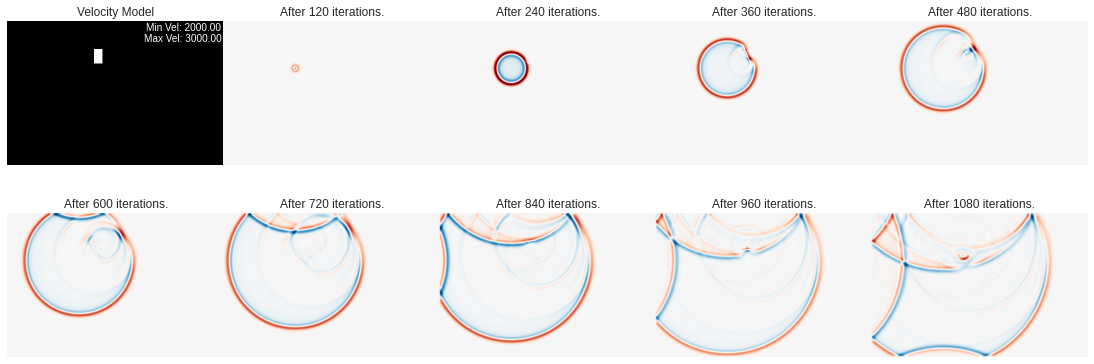

In [5]:
fv = FiniteVolume(length_x=3000, length_y=2000,
                  dt=0.0005, npts_x=500, npts_y=500,
                  space_derivative_type="pseudo_finite_volume")
fv.run_and_plot(plot_interval=120)

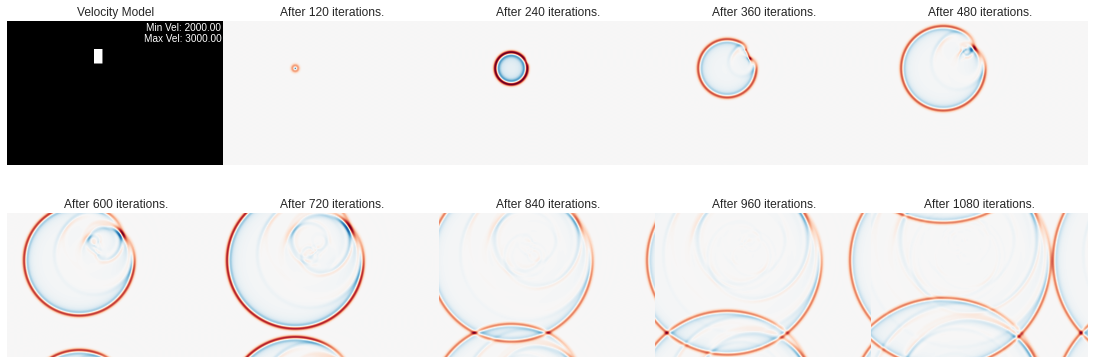

In [5]:
fv = FiniteVolume(length_x=3000, length_y=2000,
                  dt=0.0005, npts_x=500, npts_y=500,
                  space_derivative_type="pseudospectral")
fv.run_and_plot(plot_interval=120)

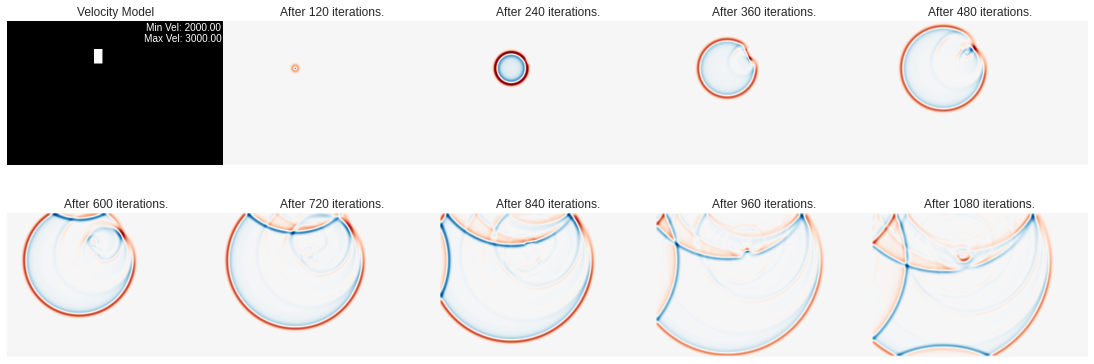

In [6]:
fv = FiniteVolume(length_x=3000, length_y=2000,
                  dt=0.0005, npts_x=500, npts_y=500,
                  space_derivative_type="second_order_FD")
fv.run_and_plot(plot_interval=120)